# <center>**Exploratory Data Analysis**</center>

---



####1.   Numpy      => Used for numerical computing and handling large multidimensional arrays.
####2.   Pandas     => Used for data manipulation and analysis with tabular data (Dataframe)
####3.   Matplotlib => Used for creating static, interactive, and animated visualizations in Python.
####4.   Seaborn    => Used for attractive and informative statistical graphics


In [ ]:
!pip install numpy pandas matplotlib seaborn  # Install Dependencies

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load your logs file
df = pd.read_csv("/content/logs_preprocessed.csv")

# convert text columns into datetime objects
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["run_date"] = pd.to_datetime(df["run_date"], errors="coerce")


### **Handling the missing values**

---



####1. df.shape => Display the number of rows and columns
####2. df.columns => List out the columns are available in the dataset.
####3. df.isna() or df.isnull => Both are used to identify the missing values.

In [ ]:
print("Data shape:", df.shape)
print("Columns:", df.columns)
print("\nMissing values:\n", df.isna().sum())

Data shape: (8605, 13)
Columns: Index(['filename', 'dut', 'dut_version', 'os_version', 'config',
       'test_case_id', 'line_number', 'timestamp', 'run_date', 'status',
       'error_msg', 'suite', 'raw_line'],
      dtype='object')

Missing values:
 filename        0
dut             0
dut_version     0
os_version      0
config          0
test_case_id    0
line_number     0
timestamp       0
run_date        0
status          0
error_msg       0
suite           0
raw_line        0
dtype: int64


####groupby("filename") => Groups the data by each unique file name.

####["timestamp"] => Selects the timestamp column within each group.

####ffill() (forward fill) => Fills missing timestamps by copying the last valid value downward within that file group.

####bfill() (backward fill) => Then fills any remaining missing values by copying the next valid value upward.

In [ ]:
#df["timestamp"] = df.groupby("filename")["timestamp"].ffill().bfill()
#df["timestamp"] = df["timestamp"].fillna(df["run_date"])

In [ ]:
print(df.isnull().sum())  # Identify the missing values

filename        0
dut             0
dut_version     0
os_version      0
config          0
test_case_id    0
line_number     0
timestamp       0
run_date        0
status          0
error_msg       0
suite           0
raw_line        0
dtype: int64


###**Volume Analysis**

---
####df["suite"].value_counts() => how many times each unique values appers in the suite column and the print suite_counts.



In [ ]:
suite_counts = df["suite"].value_counts()
print("\nExecutions per suite:\n", suite_counts)



Executions per suite:
 suite
ptp-oc       2755
dtmf         1904
ptp-bc       1703
ptp-tc       1008
sctp          499
ipv4          189
udp           166
rtp           138
sip            81
tcp            78
v6bgp4         52
ipv6-host      26
lacp            6
Name: count, dtype: int64


####This code counts and prints the number of executions per suite and then visualizes these counts in a bar chart with rotated labels for readability. It helps quickly understand the distribution of executions across different suites.

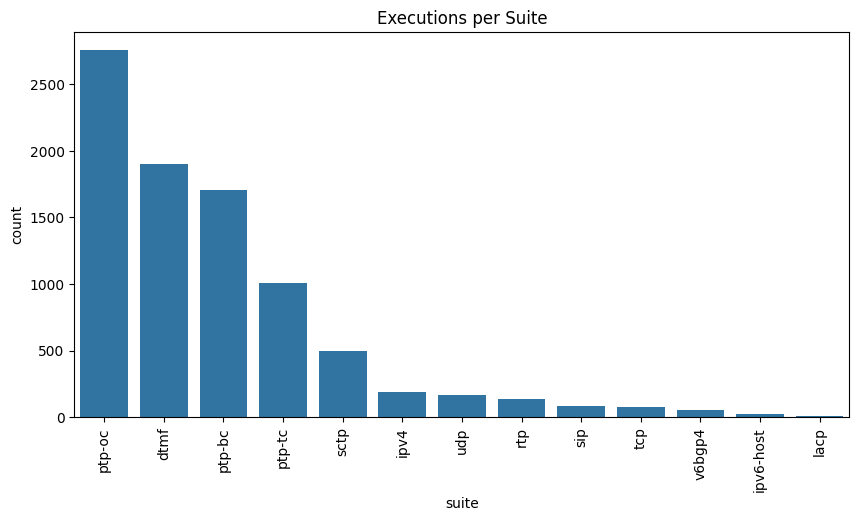

In [ ]:
plt.figure(figsize=(10,5)) # sets the plot size
sns.countplot(data=df, x="suite", order=suite_counts.index) # Draws a bar chart showing the counts for each suite
plt.title("Executions per Suite") # Add the title
plt.xticks(rotation=90) # Display the x-label 90 degree for better readability
plt.show() # Display the plot

####This code counts occurrences of each device in the "dut" column and visualizes them as a bar chart using seaborn's countplot with the bars ordered by frequency. The plot size and x-axis label rotation (90 degrees) improve readability. It provides a clear, concise visual summary of executions per DUT.

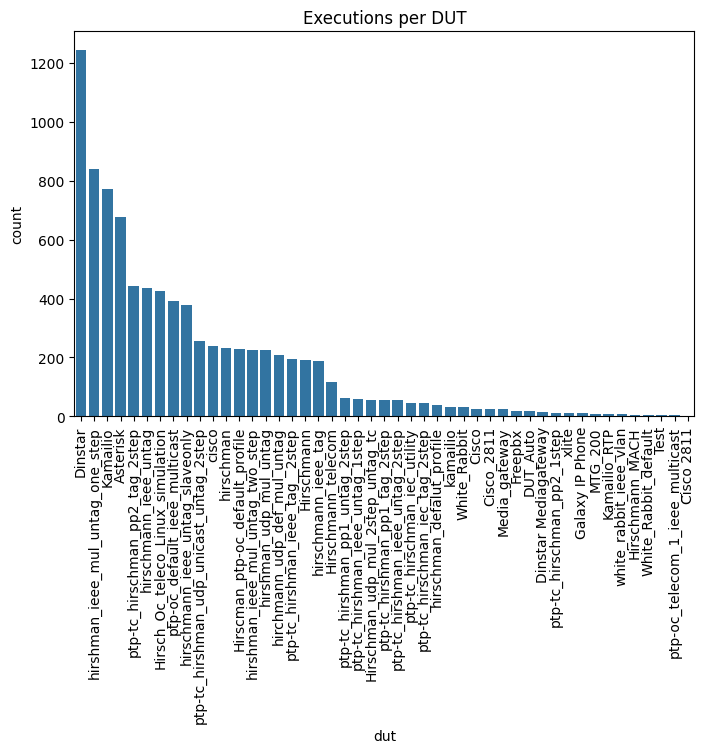

In [ ]:

dut_counts = df["dut"].value_counts() # How many times appears in the dut column
plt.figure(figsize=(8,5)) # Set the plot size
sns.countplot(data=df, x="dut", order=dut_counts.index) ## Draws a bar chart showing the counts for each dut
plt.title("Executions per DUT") # Add the title
plt.xticks(rotation=90) # Display the x-label 90 degree for readability
plt.show() # Display the plot




####This code groups the data by the "run_date" column, counts the number of executions for each date, and plots these counts over time as a line chart. It provides a clear visual trend of executions across different dates

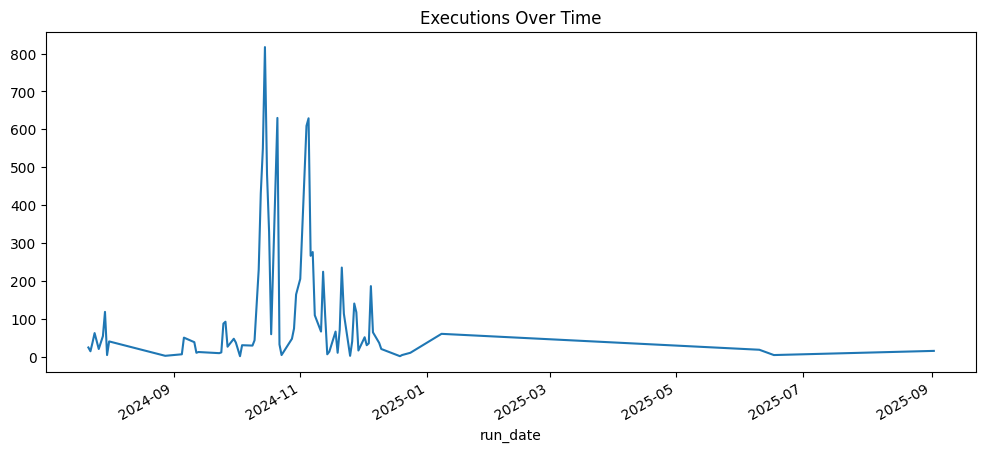

In [ ]:

daily_counts = df.groupby("run_date").size()
daily_counts.plot(figsize=(12,5), title="Executions Over Time")
plt.show()

###**Failure Distribution**


---

####1. Defines a function to clean and categorize error messages into broader categories (like License Error, Missing File, etc.) by matching known error patterns.
####2. It applies this function to the "error_msg" column to create a new "error_category" column.
####3. Then, it calculates and prints the top 10 most common failure categories among rows where the status is "FAIL."


In [ ]:
import re
def clean_error_message(msg):
    if pd.isna(msg):
        return "Unknown Error"
    text = str(msg)
    # Common known errors (add more patterns as needed)
    if "license" in text.lower():
        return "License Error"
    if "dtmf rtp packets are not received" in text.lower():
        return "DTMF RTP Packet Loss"
    if "no such file or directory" in text.lower():
        return "Missing File"
    if "execution terminated" in text.lower():
        return "Execution Terminated"
    if "sipp" in text.lower() and "error" in text.lower():
        return "SIPP Error"

    # Default: keep short version of the message (first 100 chars)
    return text[:100]

# Apply cleaning
df["error_category"] = df["error_msg"].apply(clean_error_message)

# Now recompute failure distribution
failure_dist=df[df["status"]=="FAIL"]["error_category"].value_counts().head(10)
print("Most common failure categories:\n", failure_dist)

Most common failure categories:
 error_category
with error - Capture id does not exist                                               259
or test result may be in correct.                                                    226
DUT does not transmit PDELAY_RESP message on    #                                     64
DUT does not transmit PDELAY_REQ message on     #                                     53
DUT does not transmit PDELAY_REQ message on port P1 1/5 with expected parameters      37
DUT does not transmit PDELAY_RESP message on port P1 1/5                              34
DUT has not sent the SIP packets with expected  #                                     30
DUT does not transmit PDELAY_RESP message on port P1 1/5 with expected parameters     30
for command: ptp v2tc primary-domain 256                                              27
for command: ptp v2tc primary-domain -1                                               27
Name: count, dtype: int64


###**Execution Trends**

---
####This code groups data by run date and status to track the count of each status (e.g., PASS, FAIL) over time, and then plots these counts to show trends. It also calculates and plots the pass rate over time, helping visualize overall quality improvements or regressions.


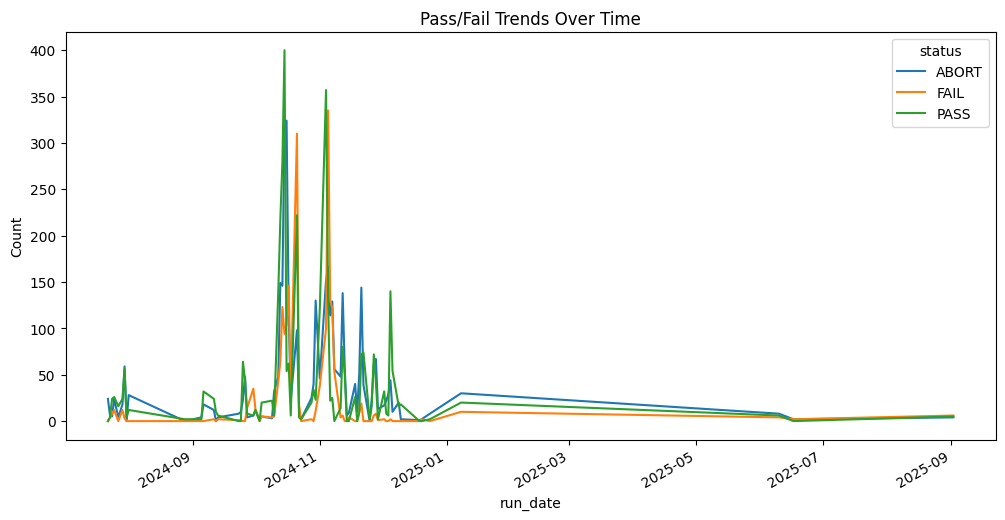

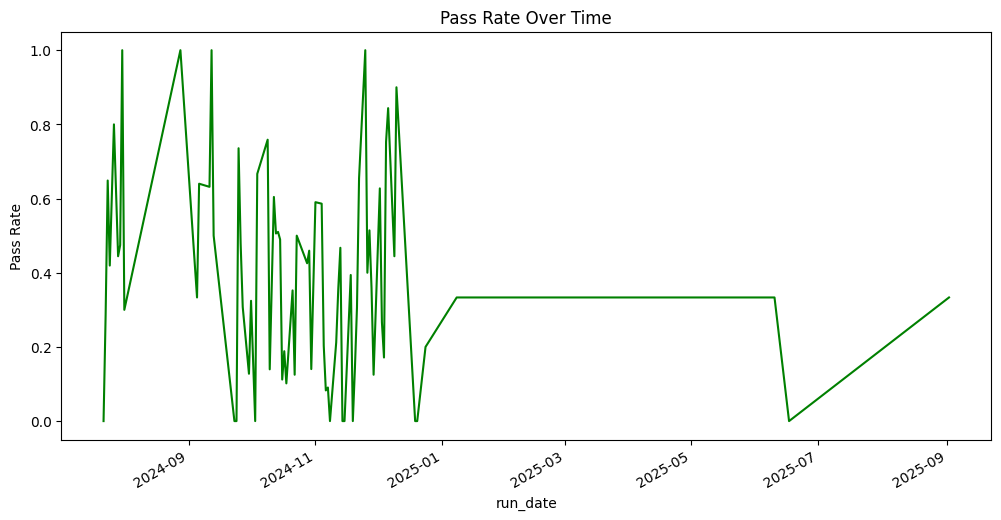

In [ ]:
# Group by run_date and status, count each group, and reshape to wide format with statuses as columns
status_trends = df.groupby([df["run_date"], "status"]).size().unstack(fill_value=0)

# Plot the counts of each status over time with a figure size of 12x6 inches
status_trends.plot(figsize=(12,6))
plt.title("Pass/Fail Trends Over Time")  # Add title to the plot
plt.ylabel("Count")  # Label y-axis as Count
plt.show()  # Show the plot

# Calculate pass rate as count of PASS divided by total counts per date
status_trends["pass_rate"] = status_trends.get("PASS", 0) / status_trends.sum(axis=1)

# Plot the pass rate over time in green color
status_trends["pass_rate"].plot(figsize=(12,6), color="green", title="Pass Rate Over Time")
plt.ylabel("Pass Rate")  # Label y-axis as Pass Rate
plt.show()  # Show the pass rate plot


###**Anomalies Ploting**


---

#### This code calculates the failure rate over time and identifies dates when the failure rate spikes unusually high compared to usual variation (using mean plus twice the standard deviation as a threshold). It prints these anomaly dates and visualizes both the failure rate and detected anomalies with a threshold line for easy spotting.




Anomaly dates (spikes in failure rate):
 run_date
2024-09-27    0.532164
2024-09-30    0.742664
2024-10-22    0.560311
2024-11-05    0.532419
dtype: float64


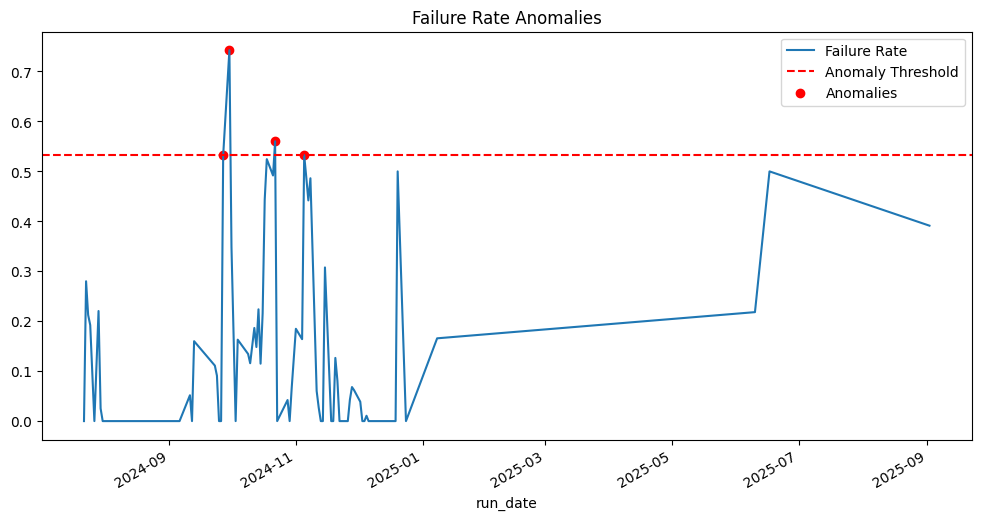

In [ ]:
# Calculate failure rate as FAIL count divided by total executions per date
failure_rate = status_trends.get("FAIL", 0) / status_trends.sum(axis=1)

# Define anomaly threshold as mean failure rate plus 2 standard deviations
threshold = failure_rate.mean() + 2 * failure_rate.std()

# Filter dates where failure rate exceeds the threshold (anomalies)
anomalies = failure_rate[failure_rate > threshold]

# Print anomaly dates and their failure rates
print("\nAnomaly dates (spikes in failure rate):\n", anomalies)

# Create plot with size 12x6 inches
plt.figure(figsize=(12,6))

# Plot failure rate over time
failure_rate.plot(label="Failure Rate")

# Draw horizontal line at anomaly threshold
plt.axhline(threshold, color="red", linestyle="--", label="Anomaly Threshold")

# Highlight anomaly points on the plot
plt.scatter(anomalies.index, anomalies.values, color="red", label="Anomalies")

# Add title and legend
plt.title("Failure Rate Anomalies")
plt.legend()

# Show the plot
plt.show()

